# Generate yellow smiley faces 🙂

## load dependencies
* matplotlib for plotting
* numpy for array handling
* json for loading emoji description
* mpimg and glob for reading PNG
* tensorflow for GAN

In [31]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import json
import glob
import random
from pprint import pprint

## filter and load emoji files

In [75]:
# filter only person emojis without tones
with open('emoji-data/emoji.json') as data_file:
    emojis = json.load(data_file)

#smileys = [e for e in emojis if e["category"] != "Symbols" and e["category"] != "Flags" and e["category"] != "Regional"]
smileys = [e for e in emojis if e["category"] == "People"]


pprint("minimized dictionary: {} left out of {} emojis".format(len(smileys), len(emojis)))
pprint(smileys[3])

'minimized dictionary: 314 left out of 1489 emojis'
{'added_in': '1.1',
 'au': None,
 'category': 'People',
 'docomo': None,
 'google': None,
 'has_img_apple': True,
 'has_img_emojione': True,
 'has_img_facebook': True,
 'has_img_google': True,
 'has_img_messenger': False,
 'has_img_twitter': True,
 'image': '2639.png',
 'name': 'WHITE FROWNING FACE',
 'sheet_x': 1,
 'sheet_y': 16,
 'short_name': 'white_frowning_face',
 'short_names': ['white_frowning_face'],
 'softbank': None,
 'sort_order': 38,
 'text': None,
 'texts': None,
 'unified': '2639',
 'variations': ['2639-FE0F']}


In [76]:
# filter all files for the given smiley unicodes
paths = [
    "emoji-data/img-apple-64",
    "emoji-data/img-emojione-64",
    "emoji-data/img-facebook-64",
    "emoji-data/img-google-64",
    "emoji-data/img-messenger-64",
    "emoji-data/img-twitter-64"
]
filenames = [s["image"] for s in smileys]
filepaths = []
for p in paths:
    image_paths = glob.glob(p + "/*.png")
    filtered = [p for p in image_paths if p.split("/")[-1] in filenames]
    filepaths = filepaths + filtered

In [135]:
def is_emoji(img):
    yellowishness = np.sum(np.logical_and(np.logical_and(img[:, :, 0] > 0.6, np.logical_and(img[:, :, 1] > 0.6, img[:, :, 3] > 0.8)), img[:, :, 2] < 0.6)) / np.sum(img[:, :, 2] < 0.6) 
    transparencyness = np.sum(img[:, :, 3] > 0.8) / (64 * 64)
    return yellowishness > 0.5 and transparencyness > 0.7

In [163]:
# load all files
images = [mpimg.imread(f) for f in filepaths]
images = [i for i in images if i.shape == (64, 64, 4)]
images = [i for i in images if is_emoji(i)]

images = [images[42]]

pprint(len(images))

1


TypeError: 'AxesSubplot' object is not subscriptable

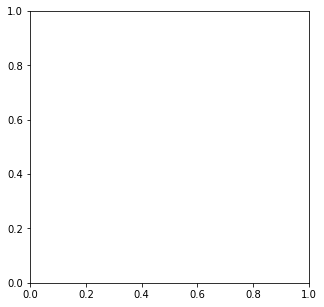

In [159]:
# display random emojis
column_count = 1 # emojis per column
display_count = column_count**2 # total number of emojis to show (aligns neatly if it's a square)

f, axarr = plt.subplots(display_count//column_count, column_count, sharex=True, sharey=True, figsize=(5,5))
for (i, img) in enumerate(random.sample(images, display_count)):
    a = axarr[i%(display_count//column_count), i//(display_count//column_count)]
    yellowishness = np.sum(np.logical_and(np.logical_and(img[:, :, 0] > 0.6, np.logical_and(img[:, :, 1] > 0.6, img[:, :, 3] > 0.8)), img[:, :, 2] < 0.6)) / np.sum(img[:, :, 2] < 0.6) 
    transparencyness = np.sum(img[:, :, 3] > 0.8) / (64 * 64)
    print("y: {}, t: {}".format(yellowishness, transparencyness))
    a.axis("off")
    a.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0)

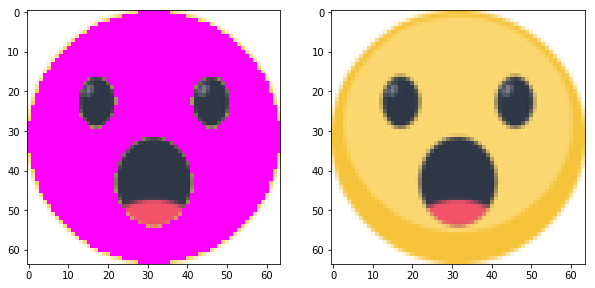

In [164]:
# figuring out how to filter for round yellow emojis..
i = images[0]
yellow_pixels = np.logical_and(i[:, :, 0] > 0.7, img[:, :, 1] > 0.7)
f, axarr = plt.subplots(1, 2, figsize=(10,10))

o = np.copy(i)
pixls = np.logical_and(np.logical_and(o[:, :, 0] > 0.6, np.logical_and(o[:, :, 1] > 0.6, o[:, :, 3] > 0.8)), o[:, :, 2] < 0.6)
o[pixls] = [1, 0, 1, 1]
axarr[0].imshow(o)
axarr[1].imshow(i)

## emojis

## preprocessing functions

In [141]:
scale_min_val=-1
scale_max_val=1
def scale(x):
    x = x / 255
    
    # scale to feature_range
    x = x * (scale_max_val - scale_min_val) + scale_min_val
    return x

def unscale(x):
    # scale to (0, 255)
   
    x = (x - scale_min_val) / (scale_max_val - scale_min_val)
    x *= 255
    return x

In [142]:
def get_batches(images, batch_size, shuffle=True):
    images = np.array(images)
    if shuffle:
        idx = np.arange(len(images))
        np.random.shuffle(idx)
        images = images[idx]
    n_batches = len(images)//batch_size
    for i in range(0, len(images), batch_size):
        x = images[i:i+batch_size]
        yield x

In [143]:
i = scale(images[0])
print(i.shape)
print(np.max(i), np.min(i))

(64, 64, 4)
-0.992157 -1.0


## define network


In [144]:
# inputs
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, *real_dim), name="input_real")
    inputs_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="input_z")

    return inputs_real, inputs_z

In [166]:
def generator(z, output_dim, reuse=False, alpha=0.2, is_train=True):
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        fc = tf.layers.dense(inputs=z, units=8*8*128, activation=None)
        conv1 = tf.reshape(fc, shape=(-1, 8, 8, 128))
        conv1 = tf.layers.batch_normalization(inputs=conv1, training=is_train)
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 8*8
        
        conv2 = tf.layers.conv2d_transpose(inputs=conv1, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=is_train)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 16*16
        
        conv3 = tf.layers.conv2d_transpose(inputs=conv1, filters=64, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=is_train)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 32*32
        
        # Output layer, 64*64
        logits = tf.layers.conv2d_transpose(inputs=conv2, filters=output_dim, kernel_size=5, strides=2, padding='SAME', activation=None)
        
        out = tf.tanh(logits)
    
    return out

In [167]:
def discriminator(x, reuse=False, alpha=0.01):

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 64*64
        conv1 = tf.layers.conv2d(inputs=x, filters=64, kernel_size=5, strides=2, padding='SAME', activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.maximum(conv1, alpha*conv1)
        # > 32*32
        
        conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv2 = tf.layers.batch_normalization(inputs=conv2, training=True)
        conv2 = tf.maximum(conv2, alpha*conv2)
        # > 16*16

        conv3 = tf.layers.conv2d(inputs=conv2, filters=256, kernel_size=5, strides=2, padding='SAME', activation=None)
        conv3 = tf.layers.batch_normalization(inputs=conv3, training=True)
        conv3 = tf.maximum(conv3, alpha*conv3)
        # > 8*8
        
        flat = tf.reshape(conv2, (-1, 8*8*128))
        logits = tf.layers.dense(inputs=flat, units=1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [168]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    smooth_factor = 0.1 # reduce true "correct" by this factor
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth_factor)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [169]:
def model_opt(d_loss, g_loss, learning_rate, beta1, beta2):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [170]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5, beta2=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1, beta2)

In [171]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = (unscale(img)).astype(np.uint8)
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [172]:
def train(net, images, epochs, batch_size, print_every=10, show_every=30, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in get_batches(images, batch_size):
                steps += 1
                x = [scale(i) for i in x]

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 4, reuse=True, is_train=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [179]:
# hyper params
real_size = (64,64,4)
z_size = 128
learning_rate = 0.003
batch_size = 32
epochs = 1000
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, beta1=beta1)

Epoch 3/1000... Discriminator Loss: 2.9843... Generator Loss: 0.3444
Epoch 6/1000... Discriminator Loss: 0.5273... Generator Loss: 2.7834
Epoch 9/1000... Discriminator Loss: 0.5096... Generator Loss: 3.3841
Epoch 12/1000... Discriminator Loss: 0.7428... Generator Loss: 10.5786
Epoch 15/1000... Discriminator Loss: 0.7735... Generator Loss: 8.4919
Epoch 18/1000... Discriminator Loss: 0.7004... Generator Loss: 2.4409
Epoch 21/1000... Discriminator Loss: 0.7100... Generator Loss: 8.0181
Epoch 24/1000... Discriminator Loss: 0.5775... Generator Loss: 5.0945
Epoch 27/1000... Discriminator Loss: 0.3661... Generator Loss: 11.6352
Epoch 30/1000... Discriminator Loss: 0.4369... Generator Loss: 6.6493
Epoch 33/1000... Discriminator Loss: 0.7544... Generator Loss: 5.4485
Epoch 36/1000... Discriminator Loss: 1.5742... Generator Loss: 11.3870
Epoch 39/1000... Discriminator Loss: 0.8546... Generator Loss: 6.1541
Epoch 42/1000... Discriminator Loss: 0.4207... Generator Loss: 8.9229
Epoch 45/1000... Dis

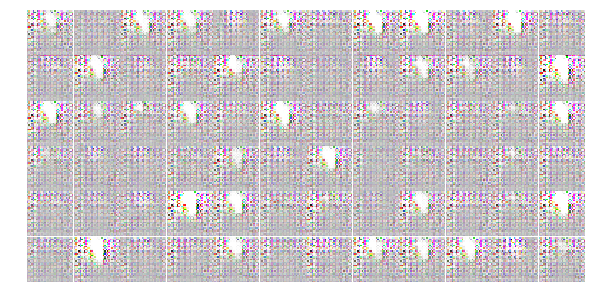

Epoch 81/1000... Discriminator Loss: 0.5314... Generator Loss: 11.6086
Epoch 84/1000... Discriminator Loss: 0.6120... Generator Loss: 9.0743
Epoch 87/1000... Discriminator Loss: 0.6865... Generator Loss: 9.9758
Epoch 90/1000... Discriminator Loss: 0.6335... Generator Loss: 9.8290
Epoch 93/1000... Discriminator Loss: 0.3802... Generator Loss: 9.0219
Epoch 96/1000... Discriminator Loss: 0.4962... Generator Loss: 7.9536
Epoch 99/1000... Discriminator Loss: 0.3811... Generator Loss: 10.3777
Epoch 102/1000... Discriminator Loss: 0.5676... Generator Loss: 8.2617
Epoch 105/1000... Discriminator Loss: 0.4650... Generator Loss: 8.0287
Epoch 108/1000... Discriminator Loss: 0.4679... Generator Loss: 8.2050
Epoch 111/1000... Discriminator Loss: 0.3877... Generator Loss: 9.8810
Epoch 114/1000... Discriminator Loss: 0.4125... Generator Loss: 9.6837
Epoch 117/1000... Discriminator Loss: 0.3721... Generator Loss: 10.1825
Epoch 120/1000... Discriminator Loss: 0.6711... Generator Loss: 10.8114
Epoch 123

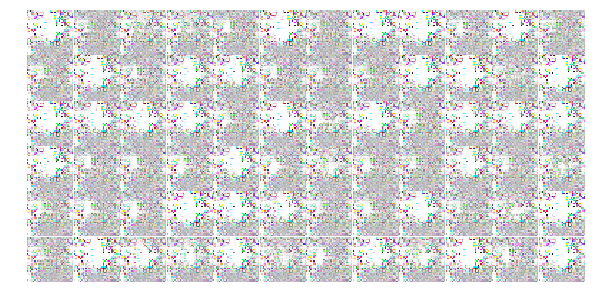

Epoch 162/1000... Discriminator Loss: 0.3856... Generator Loss: 10.3161
Epoch 165/1000... Discriminator Loss: 0.4211... Generator Loss: 9.3749
Epoch 168/1000... Discriminator Loss: 0.3626... Generator Loss: 9.5523
Epoch 171/1000... Discriminator Loss: 0.4733... Generator Loss: 8.6449
Epoch 174/1000... Discriminator Loss: 0.3846... Generator Loss: 10.1603
Epoch 177/1000... Discriminator Loss: 0.6827... Generator Loss: 10.0061
Epoch 180/1000... Discriminator Loss: 0.4487... Generator Loss: 9.1216
Epoch 183/1000... Discriminator Loss: 0.4577... Generator Loss: 8.6519
Epoch 186/1000... Discriminator Loss: 0.4106... Generator Loss: 9.4428
Epoch 189/1000... Discriminator Loss: 0.3366... Generator Loss: 9.9859
Epoch 192/1000... Discriminator Loss: 0.4263... Generator Loss: 10.1563
Epoch 195/1000... Discriminator Loss: 0.4569... Generator Loss: 10.0968
Epoch 198/1000... Discriminator Loss: 0.4577... Generator Loss: 9.5278
Epoch 201/1000... Discriminator Loss: 0.4807... Generator Loss: 9.4919
E

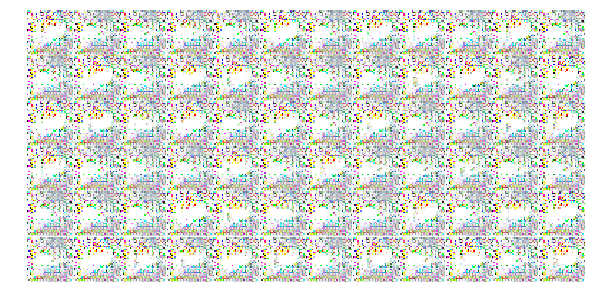

Epoch 243/1000... Discriminator Loss: 0.3855... Generator Loss: 9.8789
Epoch 246/1000... Discriminator Loss: 0.3580... Generator Loss: 9.0387
Epoch 249/1000... Discriminator Loss: 0.5625... Generator Loss: 9.9717
Epoch 252/1000... Discriminator Loss: 0.3739... Generator Loss: 8.9233
Epoch 255/1000... Discriminator Loss: 0.4251... Generator Loss: 9.0901
Epoch 258/1000... Discriminator Loss: 0.3469... Generator Loss: 9.0596
Epoch 261/1000... Discriminator Loss: 0.4751... Generator Loss: 10.1428
Epoch 264/1000... Discriminator Loss: 0.4055... Generator Loss: 10.2680
Epoch 267/1000... Discriminator Loss: 0.3641... Generator Loss: 10.6024
Epoch 270/1000... Discriminator Loss: 0.4033... Generator Loss: 8.8956
Epoch 273/1000... Discriminator Loss: 0.3826... Generator Loss: 9.5317
Epoch 276/1000... Discriminator Loss: 0.3621... Generator Loss: 9.9581
Epoch 279/1000... Discriminator Loss: 0.5325... Generator Loss: 10.3228
Epoch 282/1000... Discriminator Loss: 0.3582... Generator Loss: 9.9330
Ep

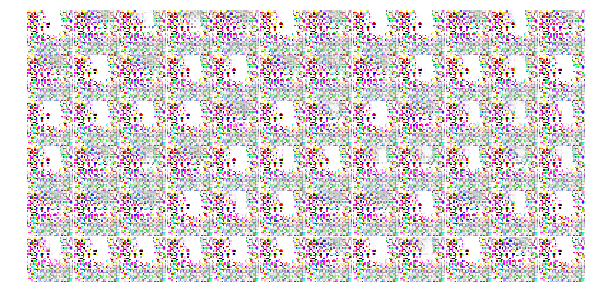

Epoch 321/1000... Discriminator Loss: 0.4415... Generator Loss: 11.5540
Epoch 324/1000... Discriminator Loss: 0.4011... Generator Loss: 10.1822
Epoch 327/1000... Discriminator Loss: 0.3796... Generator Loss: 11.1468
Epoch 330/1000... Discriminator Loss: 0.4013... Generator Loss: 11.2335
Epoch 333/1000... Discriminator Loss: 0.3337... Generator Loss: 10.9189
Epoch 336/1000... Discriminator Loss: 0.4067... Generator Loss: 11.2313
Epoch 339/1000... Discriminator Loss: 0.3632... Generator Loss: 10.4919
Epoch 342/1000... Discriminator Loss: 0.3521... Generator Loss: 10.9752
Epoch 345/1000... Discriminator Loss: 0.3268... Generator Loss: 11.4680
Epoch 348/1000... Discriminator Loss: 0.3653... Generator Loss: 11.6118
Epoch 351/1000... Discriminator Loss: 0.4123... Generator Loss: 10.7797
Epoch 354/1000... Discriminator Loss: 0.3943... Generator Loss: 11.7651
Epoch 357/1000... Discriminator Loss: 0.5107... Generator Loss: 11.2193
Epoch 360/1000... Discriminator Loss: 0.4154... Generator Loss: 

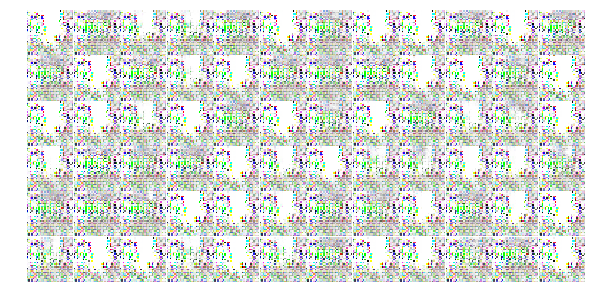

Epoch 402/1000... Discriminator Loss: 0.3543... Generator Loss: 11.3317
Epoch 405/1000... Discriminator Loss: 0.3372... Generator Loss: 11.6567
Epoch 408/1000... Discriminator Loss: 0.3920... Generator Loss: 11.4674
Epoch 411/1000... Discriminator Loss: 0.4047... Generator Loss: 11.6389
Epoch 414/1000... Discriminator Loss: 0.3757... Generator Loss: 11.1897
Epoch 417/1000... Discriminator Loss: 0.3773... Generator Loss: 11.3748
Epoch 420/1000... Discriminator Loss: 0.4213... Generator Loss: 11.1952
Epoch 423/1000... Discriminator Loss: 0.4275... Generator Loss: 11.0080
Epoch 426/1000... Discriminator Loss: 0.4030... Generator Loss: 10.1542
Epoch 429/1000... Discriminator Loss: 0.3332... Generator Loss: 11.0298
Epoch 432/1000... Discriminator Loss: 0.3855... Generator Loss: 10.6241
Epoch 435/1000... Discriminator Loss: 0.4193... Generator Loss: 9.8564
Epoch 438/1000... Discriminator Loss: 0.4307... Generator Loss: 10.4922
Epoch 441/1000... Discriminator Loss: 0.4074... Generator Loss: 9

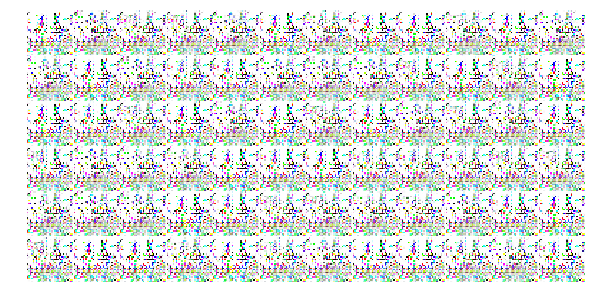

Epoch 483/1000... Discriminator Loss: 0.4047... Generator Loss: 11.0791
Epoch 486/1000... Discriminator Loss: 0.3690... Generator Loss: 10.1655
Epoch 489/1000... Discriminator Loss: 0.3374... Generator Loss: 10.0786
Epoch 492/1000... Discriminator Loss: 0.3914... Generator Loss: 9.1973
Epoch 495/1000... Discriminator Loss: 0.3627... Generator Loss: 9.7881
Epoch 498/1000... Discriminator Loss: 0.3463... Generator Loss: 9.7046
Epoch 501/1000... Discriminator Loss: 0.3815... Generator Loss: 9.7325
Epoch 504/1000... Discriminator Loss: 0.3759... Generator Loss: 10.1461
Epoch 507/1000... Discriminator Loss: 0.3552... Generator Loss: 9.9083
Epoch 510/1000... Discriminator Loss: 0.3656... Generator Loss: 11.0342
Epoch 513/1000... Discriminator Loss: 0.3884... Generator Loss: 10.6629
Epoch 516/1000... Discriminator Loss: 0.3941... Generator Loss: 10.4117
Epoch 519/1000... Discriminator Loss: 0.3746... Generator Loss: 10.9021
Epoch 522/1000... Discriminator Loss: 0.3487... Generator Loss: 10.64

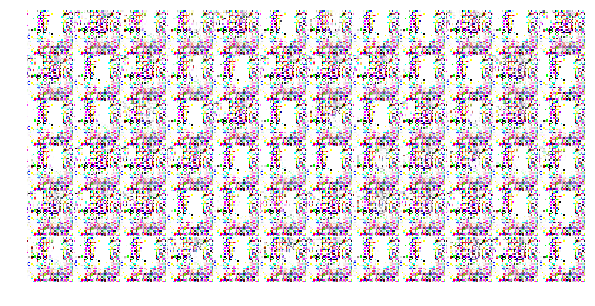

Epoch 561/1000... Discriminator Loss: 0.3805... Generator Loss: 11.1694
Epoch 564/1000... Discriminator Loss: 0.3756... Generator Loss: 10.9954
Epoch 567/1000... Discriminator Loss: 0.3307... Generator Loss: 11.0007
Epoch 570/1000... Discriminator Loss: 0.3408... Generator Loss: 11.1925
Epoch 573/1000... Discriminator Loss: 0.3638... Generator Loss: 10.9091
Epoch 576/1000... Discriminator Loss: 0.3560... Generator Loss: 11.0544
Epoch 579/1000... Discriminator Loss: 0.3777... Generator Loss: 11.0059
Epoch 582/1000... Discriminator Loss: 0.3488... Generator Loss: 11.9401
Epoch 585/1000... Discriminator Loss: 0.3504... Generator Loss: 11.2597
Epoch 588/1000... Discriminator Loss: 0.4103... Generator Loss: 10.2199
Epoch 591/1000... Discriminator Loss: 0.3659... Generator Loss: 10.6711
Epoch 594/1000... Discriminator Loss: 0.3796... Generator Loss: 10.7655
Epoch 597/1000... Discriminator Loss: 0.3688... Generator Loss: 10.8277
Epoch 600/1000... Discriminator Loss: 0.3372... Generator Loss: 

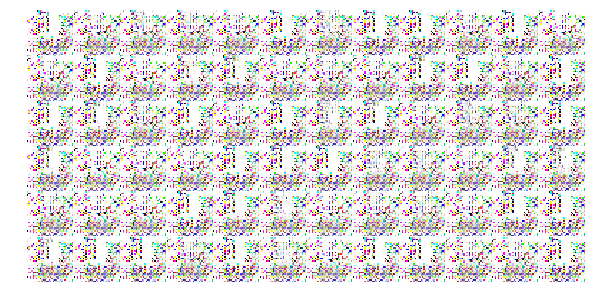

Epoch 642/1000... Discriminator Loss: 0.3526... Generator Loss: 11.3823
Epoch 645/1000... Discriminator Loss: 0.3311... Generator Loss: 10.7318
Epoch 648/1000... Discriminator Loss: 0.3335... Generator Loss: 11.2126
Epoch 651/1000... Discriminator Loss: 0.3723... Generator Loss: 10.8681
Epoch 654/1000... Discriminator Loss: 0.3587... Generator Loss: 8.9645
Epoch 657/1000... Discriminator Loss: 0.4003... Generator Loss: 10.9501
Epoch 660/1000... Discriminator Loss: 0.3784... Generator Loss: 11.3235
Epoch 663/1000... Discriminator Loss: 0.3741... Generator Loss: 11.4464
Epoch 666/1000... Discriminator Loss: 0.3536... Generator Loss: 10.0804
Epoch 669/1000... Discriminator Loss: 0.3519... Generator Loss: 10.6663
Epoch 672/1000... Discriminator Loss: 0.4312... Generator Loss: 10.6583
Epoch 675/1000... Discriminator Loss: 0.3261... Generator Loss: 9.7298
Epoch 678/1000... Discriminator Loss: 0.3841... Generator Loss: 9.0290
Epoch 681/1000... Discriminator Loss: 0.3593... Generator Loss: 10.

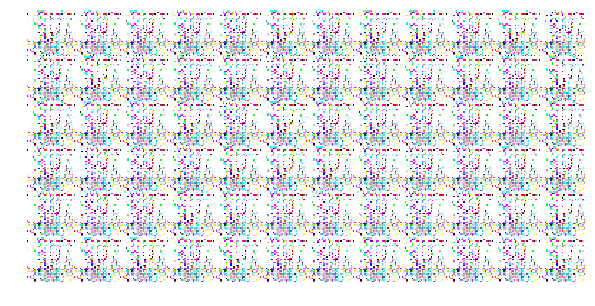

Epoch 723/1000... Discriminator Loss: 0.3816... Generator Loss: 11.1887
Epoch 726/1000... Discriminator Loss: 0.3432... Generator Loss: 11.0068
Epoch 729/1000... Discriminator Loss: 0.3523... Generator Loss: 11.2331
Epoch 732/1000... Discriminator Loss: 0.3418... Generator Loss: 11.9966
Epoch 735/1000... Discriminator Loss: 0.3334... Generator Loss: 11.6141
Epoch 738/1000... Discriminator Loss: 0.3860... Generator Loss: 11.6797
Epoch 741/1000... Discriminator Loss: 0.3262... Generator Loss: 11.4960
Epoch 744/1000... Discriminator Loss: 0.3479... Generator Loss: 11.3620
Epoch 747/1000... Discriminator Loss: 0.3364... Generator Loss: 10.8389
Epoch 750/1000... Discriminator Loss: 0.3397... Generator Loss: 10.8641
Epoch 753/1000... Discriminator Loss: 0.3699... Generator Loss: 10.4426
Epoch 756/1000... Discriminator Loss: 0.3522... Generator Loss: 10.3185
Epoch 759/1000... Discriminator Loss: 0.3503... Generator Loss: 10.4937
Epoch 762/1000... Discriminator Loss: 0.3803... Generator Loss: 

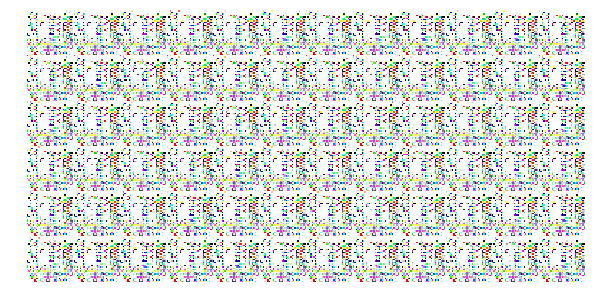

Epoch 801/1000... Discriminator Loss: 0.3320... Generator Loss: 10.6438
Epoch 804/1000... Discriminator Loss: 0.3295... Generator Loss: 10.9352
Epoch 807/1000... Discriminator Loss: 0.3729... Generator Loss: 11.6325
Epoch 810/1000... Discriminator Loss: 0.3428... Generator Loss: 11.4385
Epoch 813/1000... Discriminator Loss: 0.3367... Generator Loss: 10.6642
Epoch 816/1000... Discriminator Loss: 0.4211... Generator Loss: 12.2281
Epoch 819/1000... Discriminator Loss: 0.3358... Generator Loss: 10.8816
Epoch 822/1000... Discriminator Loss: 0.3444... Generator Loss: 9.8484
Epoch 825/1000... Discriminator Loss: 0.3436... Generator Loss: 10.4581
Epoch 828/1000... Discriminator Loss: 0.3260... Generator Loss: 11.3141
Epoch 831/1000... Discriminator Loss: 0.3573... Generator Loss: 11.1083
Epoch 834/1000... Discriminator Loss: 0.3686... Generator Loss: 11.1619
Epoch 837/1000... Discriminator Loss: 0.3373... Generator Loss: 11.5943
Epoch 840/1000... Discriminator Loss: 0.3527... Generator Loss: 1

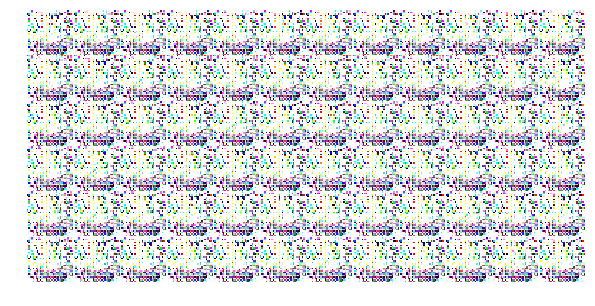

Epoch 882/1000... Discriminator Loss: 0.3833... Generator Loss: 10.6083
Epoch 885/1000... Discriminator Loss: 0.3263... Generator Loss: 10.9419
Epoch 888/1000... Discriminator Loss: 0.4184... Generator Loss: 11.5956
Epoch 891/1000... Discriminator Loss: 0.3516... Generator Loss: 10.7544
Epoch 894/1000... Discriminator Loss: 0.3272... Generator Loss: 11.0083
Epoch 897/1000... Discriminator Loss: 0.3779... Generator Loss: 11.4826
Epoch 900/1000... Discriminator Loss: 0.3428... Generator Loss: 10.8633
Epoch 903/1000... Discriminator Loss: 0.3298... Generator Loss: 11.4076
Epoch 906/1000... Discriminator Loss: 0.3529... Generator Loss: 12.0687
Epoch 909/1000... Discriminator Loss: 0.3791... Generator Loss: 11.6598
Epoch 912/1000... Discriminator Loss: 0.3509... Generator Loss: 11.7700
Epoch 915/1000... Discriminator Loss: 0.3351... Generator Loss: 12.0945
Epoch 918/1000... Discriminator Loss: 0.3621... Generator Loss: 11.4225
Epoch 921/1000... Discriminator Loss: 0.3572... Generator Loss: 

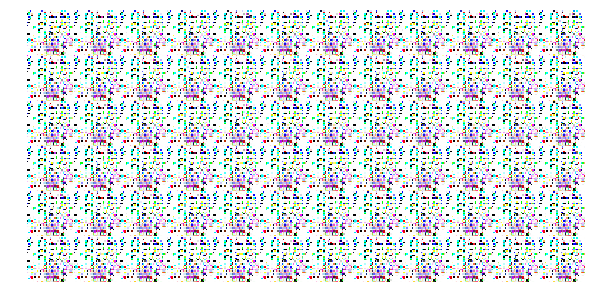

Epoch 963/1000... Discriminator Loss: 0.3363... Generator Loss: 11.6702
Epoch 966/1000... Discriminator Loss: 0.3578... Generator Loss: 11.5326
Epoch 969/1000... Discriminator Loss: 0.3331... Generator Loss: 11.0956
Epoch 972/1000... Discriminator Loss: 0.3565... Generator Loss: 10.8427
Epoch 975/1000... Discriminator Loss: 0.3334... Generator Loss: 10.9224
Epoch 978/1000... Discriminator Loss: 0.3506... Generator Loss: 11.6370
Epoch 981/1000... Discriminator Loss: 0.3524... Generator Loss: 11.7609
Epoch 984/1000... Discriminator Loss: 0.3550... Generator Loss: 11.1688
Epoch 987/1000... Discriminator Loss: 0.3545... Generator Loss: 11.0660
Epoch 990/1000... Discriminator Loss: 0.3570... Generator Loss: 10.5225
Epoch 993/1000... Discriminator Loss: 0.3419... Generator Loss: 10.5377
Epoch 996/1000... Discriminator Loss: 0.3477... Generator Loss: 11.9013
Epoch 999/1000... Discriminator Loss: 0.3580... Generator Loss: 11.0052


In [180]:
# Load the data and train the network here
losses, samples = train(net, images, epochs, batch_size, print_every=3, show_every=80, figsize=(10,5))

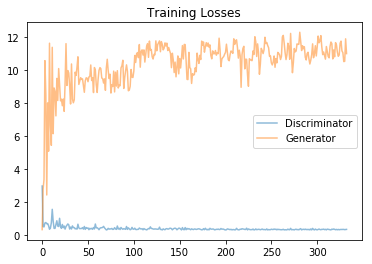

In [181]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))